# Linear Regression from Scratch

This project implements linear regression from scratch using NumPy to understand the full machine learning pipeline.

As a reference, the final results are compared with scikit-learn's LinearRegression implementation.

## Dataset

The project uses the California Housing dataset from scikit-learn.

Each row represents aggregated housing statistics for a census block group in California.
The target variable is MedHouseVal - the median house value (measured in hundreds of thousands of dollars).

The dataset contains numerical features only, which makes it suitable for implementing linear regression from scratch.

In [1]:
import sys
sys.path.append("..")

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn (dataset import last as requested)
from sklearn.datasets import fetch_california_housing

# Project modules
from src.model import LinearRegressionScratch
from src.preprocessing import train_val_test_split, fit_zscore, transform_zscore
from src.loss import rmse
from src.plotting import plot_feature_vs_target, plot_predicted_vs_actual

### Data loading and inspection

In [2]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Data preprocessing

First, the target variable **MedHouseVal** is separated from the input features.
The data is then split into training, validation, and test sets (70% / 15% / 15%).

Z-score normalization is applied to all features.
The mean and standard deviation are computed on the training set only and reused for validation and test sets to avoid data leakage.

In [ ]:
X = df.drop(columns="MedHouseVal").to_numpy()
y = df["MedHouseVal"].to_numpy()
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, 0.7, 0.15, 52)
mu, std = fit_zscore(X_train)

X_train = transform_zscore(X_train, mu, std)
X_val = transform_zscore(X_val, mu, std)
X_test = transform_zscore(X_test, mu, std)

## Training and evaluating the baseline linear regression model

The linear regression model is trained on the training set using batch gradient descent.
Predictions are then generated for both the training and validation sets, and model performance is evaluated using RMSE.

In [4]:
model = LinearRegressionScratch(alpha=0.01, num_iters=3000)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
print("RMSE train:", rmse(y_train, y_pred_train))
print("RMSE val:  ", rmse(y_val, y_pred_val))

RMSE train: 0.7216501188911695
RMSE val:   0.7494419753835607


### Training dynamics

The loss curve demonstrates stable convergence of batch gradient descent.
Most of the error reduction occurs within the first few hundred iterations, after which the optimization reaches a plateau, indicating practical convergence.

For this reason, the plot is focused on the first 750 iterations to better illustrate the main convergence behavior.
The chosen number of 3000 iterations ensures convergence without unnecessary computation.

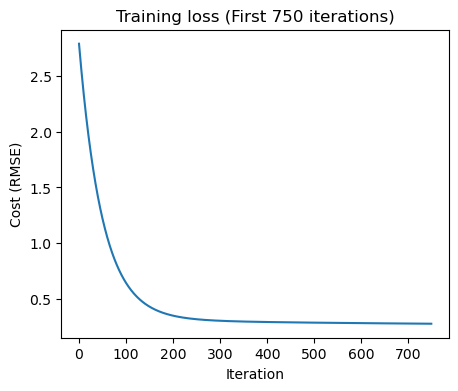

In [5]:
plt.figure(figsize = (5, 4))
plt.plot(model.cost_history[:750])
plt.xlabel("Iteration")
plt.ylabel("Cost (RMSE)")
plt.title("Training loss (First 750 iterations)")
plt.show()

### Baseline comparison
As a simple baseline, the model predicts the mean target value for all samples.
The baseline RMSE is significantly higher than the trained model’s RMSE, confirming that the model learns meaningful relationships from the data.

In [6]:
baseline = np.mean(y_train)
y_pred_base = np.full_like(y_val, baseline)
print("RMSE baseline train: ", rmse(y_val, y_pred_base))

RMSE baseline train:  1.1757241695757534


**Results and interpretation**

The baseline model shows underfitting but already performs significantly better than a naive mean predictor.

## Feature analysis

The following features are selected for visualization to understand their individual relationship with the target variable and to guide feature engineering decisions.

Geographic features (Latitude, Longitude) are plotted to inspect spatial patterns in housing prices.
MedInc is visualized due to its known strong influence on housing value and its potentially non-linear relationship with the target.

Highly skewed features (Population, AveOccup) are also analyzed, as their raw distributions contain extreme outliers.
For these features, the top 1% of values is excluded from visualization to focus on the dominant data mass and reveal meaningful trends.

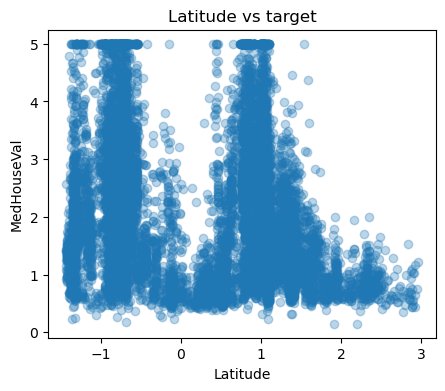

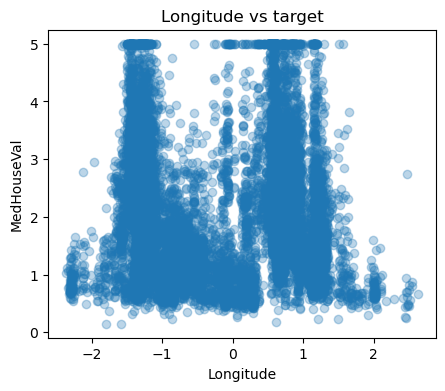

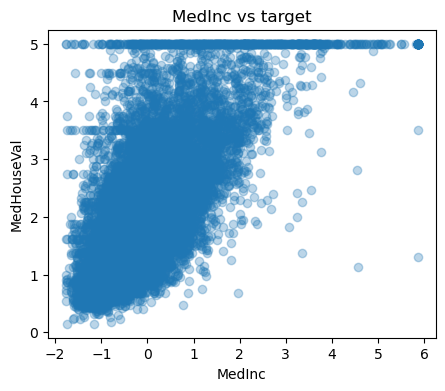

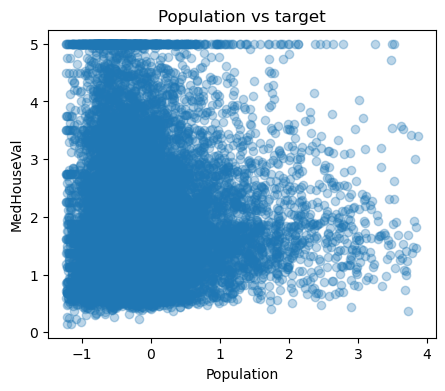

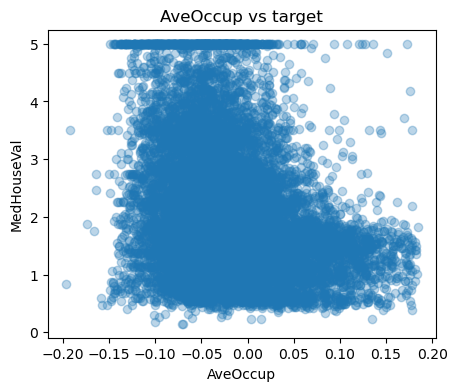

In [7]:
plot_feature_vs_target(X_train[:, 6], y_train, "Latitude")
plot_feature_vs_target(X_train[:, 7], y_train, "Longitude")
plot_feature_vs_target(X_train[:, 0], y_train, "MedInc")


p99_pop = np.percentile(X_train[:, 4], 99)
p99_occ = np.percentile(X_train[:, 5], 99)

mask_pop = X_train[:, 4] <= p99_pop
mask_occ = X_train[:, 5] <= p99_occ

plot_feature_vs_target(X_train[mask_pop, 4], y_train[mask_pop], "Population")
plot_feature_vs_target(X_train[mask_occ, 5], y_train[mask_occ], "AveOccup")




## Feature engineering

Based on the feature–target analysis, several engineered features are introduced to better capture non-linear relationships and spatial effects in housing prices.

Squared latitude and longitude terms are added to model non-linear geographic patterns, as housing prices exhibit multiple local maxima across California. An interaction term between latitude and longitude is included to capture joint spatial dependencies that cannot be represented by independent linear terms.

To better model coastal effects, distances to two major high-value coastal regions — San Francisco (≈ −122 longitude) and Los Angeles (≈ −118 longitude) — are constructed using absolute distance along the longitude axis. These distances are further transformed using a decaying function

$$
f(x) = \frac{1}{1 + x}
$$

which emphasizes proximity effects: properties closer to these coastal hubs receive higher feature values, while the influence smoothly decreases with distance.

The relationship between median income and housing prices is clearly non-linear; a square root transformation is applied as it yields lower validation error compared to logarithmic scaling.

Population-related effects are captured through a density feature combining population and average occupancy. This reflects housing demand intensity more accurately than raw population counts.

Finally, the bedrooms-to-rooms ratio is introduced as a structural feature. Higher-priced houses tend to have more total rooms relative to bedrooms, making this ratio a meaningful proxy for housing quality.

In [8]:
df_fe = df.copy()
df_fe["Lat_Sq"] = df_fe["Latitude"] ** 2
df_fe["Lon_Sq"] = df_fe["Longitude"] ** 2
df_fe["Lat_Lon"] = df_fe["Latitude"] * df_fe["Longitude"]
df_fe["DistToSF_lon"] = np.abs(df_fe["Longitude"] + 122)
df_fe["DistToLA_lon"] = np.abs(df_fe["Longitude"] + 118)
df_fe["CoastSF"] = 1 / (1 + df_fe["DistToSF_lon"])
df_fe["CoastLA"] = 1 / (1 + df_fe["DistToLA_lon"])
df_fe["MedInc_Sq"] = np.sqrt(df_fe["MedInc"])
df_fe["Density"] = np.sqrt(df_fe["Population"] / df_fe["AveOccup"])
df_fe["Bedrooms_Ratio"] = df_fe["AveBedrms"] / df_fe["AveRooms"]


### Train / validation / test split and normalization

In [ ]:
X = df_fe.drop(columns="MedHouseVal").to_numpy()
y = df_fe["MedHouseVal"].to_numpy()

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, 0.7, 0.15, 52)
mu, std = fit_zscore(X_train)

X_train = transform_zscore(X_train, mu, std)
X_val = transform_zscore(X_val, mu, std)
X_test = transform_zscore(X_test, mu, std)

### Model training and evaluation

In [ ]:
model = LinearRegressionScratch(alpha=0.01, num_iters=3000)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print("RMSE train:", rmse(y_train, y_pred_train))
print("RMSE val:  ", rmse(y_val, y_pred_val))

RMSE train: 0.6862829614776993
RMSE val:   0.7098033694455782


**Results and interpretation** 

*The table below demonstrates model performance before and after feature engineering.*
| Model version | Train RMSE | Validation RMSE |
|---------------|------------|-----------------|
| Baseline (no FE) | 0.722 | 0.749 |
| After FE         | 0.687 | 0.710 |

The introduction of engineered features leads to a noticeable improvement in performance on both the training and validation sets.

Train RMSE decreases from approximately 0.721 to 0.688, while validation RMSE drops from approximately 0.749 to 0.710.  
This consistent improvement across both splits indicates that feature engineering improves the model's expressive power without causing overfitting.

The reduced validation error confirms that the added spatial, interaction, and non-linear transformations better capture the underlying structure of the data.

## Regularization experiment

To evaluate the effect of L2 regularization, a small grid of regularization strengths (λ) is tested.
For each value of λ, a linear regression model is trained on the training set using the same learning rate and number of iterations.
Model performance is then evaluated on the validation set using RMSE.

This controlled experiment isolates the impact of the regularization term while keeping all other hyperparameters fixed.

In [11]:
lambdas = [0.0, 0.001, 0.01, 0.1, 1.0]

results = []

for l2 in lambdas:
    model = LinearRegressionScratch(alpha=0.01, num_iters=3000, l2_lambda=l2)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    rmse_val = rmse(y_val, y_pred_val)

    results.append((l2, rmse_val))
    print(f"l2_lambda={l2:<6} | RMSE val = {rmse_val:.8f}")


l2_lambda=0.0    | RMSE val = 0.70980337
l2_lambda=0.001  | RMSE val = 0.70980338
l2_lambda=0.01   | RMSE val = 0.70980344
l2_lambda=0.1    | RMSE val = 0.70980406
l2_lambda=1.0    | RMSE val = 0.70981025


**Results and interpretation**

The validation RMSE remains nearly constant for very small values of λ and slightly increases as λ grows larger.
This indicates that the baseline model is not overfitting and does not benefit from additional regularization.

The best validation performance is achieved when λ = 0, meaning no regularization.

## Final model evaluation on test set

After finalizing feature engineering and model configuration using the training and validation sets, the model is evaluated on the held-out test set to assess its generalization performance.

In [12]:
y_pred_test = model.predict(X_test)
print("RMSE train: ", rmse(y_test, y_pred_test))

RMSE train:  0.6784648317040445


### Predicted vs Actual (Test set)
Visualization of model accuracy, where the dashed diagonal line represents perfect predictions (y = x).

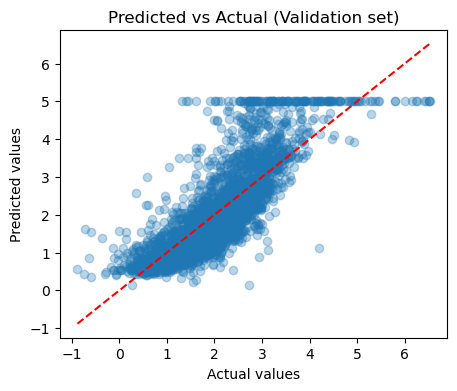

Max house price:  5.00001


In [13]:
plot_predicted_vs_actual(y_pred_test, y_test)
print("Max house price: ", df["MedHouseVal"].max())

**Results and interpretation**

The horizontal concentration of points around the maximum target value is caused by censoring in the California Housing dataset.

The target variable MedHouseVal is capped at 5.0, which corresponds to median house values above $500,000 being clipped to this upper bound. As a result, all more expensive houses share the same target value, even though their true prices may differ significantly.

This leads to increased prediction error for high-value properties and explains the visible deviation from the ideal y = x line in the upper range of the plot. Importantly, this behavior is a dataset limitation rather than a model failure.

As a result, predictions in the upper target range (4–5) become less accurate due to the artificial upper bound of the target variable at 5.0, which limits the model’s ability to learn precise price differences near the maximum.

## Sklearn comparison

To validate the correctness and quality of the from-scratch implementation, the final model is compared against scikit-learn’s LinearRegression, which serves as a well-optimized reference implementation.

Both models are trained on the same preprocessed data, including:
	•	identical train / validation / test splits
	•	identical feature engineering
	•	identical normalization

This ensures a fair and meaningful comparison.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
# обучаем sklearn-модель
sk_model = LinearRegression()
sk_model.fit(X_train, y_train)

# предсказания
y_pred_train_sk = sk_model.predict(X_train)
y_pred_val_sk = sk_model.predict(X_val)
y_pred_test_sk = sk_model.predict(X_test)

# RMSE
rmse_train_sk = np.sqrt(mean_squared_error(y_train, y_pred_train_sk))
rmse_val_sk = np.sqrt(mean_squared_error(y_val, y_pred_val_sk))
rmse_test_sk = np.sqrt(mean_squared_error(y_test, y_pred_test_sk))

print("SKLEARN RMSE train:", rmse_train_sk)
print("SKLEARN RMSE val:  ", rmse_val_sk)
print("SKLEARN RMSE test: ", rmse_test_sk)

SKLEARN RMSE train: 0.6647420451049109
SKLEARN RMSE val:   0.6926297107049738
SKLEARN RMSE test:  0.6549017745855263


**Results and interpretation**

*The table below summarizes the RMSE values for both implementations:*
| Model                | Train RMSE | Validation RMSE | Test RMSE |
|----------------------|------------|------------------|-----------|
| Scratch (Gradient Descent) | 0.687 | 0.710 | 0.678 |
| Scikit-learn (Closed-form) | 0.665 | 0.693 | 0.655 |

The scikit-learn model achieves slightly lower error across all splits, which is expected due to: closed-form optimization (normal equation/SVD), numerical stability optimizations and absence of learning-rate–related approximation error

Despite these differences, the from-scratch model achieves comparable performance, with only a small gap in RMSE.
This confirms that the gradient descent implementation is correct, it generalizes well and does not overfit



## Conclusion

This notebook shows that a linear regression model implemented from scratch can achieve performance close to scikit-learn when preprocessing and feature engineering are done correctly.

Most of the performance improvement comes from feature engineering rather than the choice of optimizer. While scikit-learn achieves slightly lower RMSE due to its closed-form solution and numerical stability, the scratch implementation converges reliably and generalizes well.

The project demonstrates both practical modeling performance and a clear understanding of the full machine learning pipeline.